In [3]:
import jax
import jax.numpy as np
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy,pickle
from jax.tree_util import tree_map, tree_flatten
from jax.flatten_util import ravel_pytree

from jax import jit,vmap
import pandas as pd
import blackjax
from jax import lax



import sys,os,importlib,pdb
sys.path.append('/mnt/home/szheng/projects/util_code')
import gm

import scipy
from scipy.signal import find_peaks
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload

import copy

%matplotlib inline
import gm_glm_bayesian as glm
import gm_glm_bayesian_helper as glmh
import math_functions as mf
import plot_mcmc as pmc
reload(pmc)

import gm_cv as gc
import glm_cv as glmc

In [4]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
fr_map_ = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']
fr_map_avg=pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map']
cell_cols = fr_['cell_cols']

In [5]:
unit_int = 31
unit_str = f'unit_{unit_int}'

unit_ind_in_pyr = [i for i in range(len(cell_cols['pyr']))  if unit_str == cell_cols['pyr'][i]][0]

trial_ind_dict = dict(fr.groupby('visitedArm')['trial'].unique())
fr_map_one_unit_both_trials_dict = {k:val[unit_ind_in_pyr] for k,val in fr_map_.items()}
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)

pars_rand=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)

# fr_filtered=fr.query("(vel_lin>=5.)&(trial==0)")
# fr_ = fr_filtered
fr_=fr
regressors=glm.get_regressors(fr_)
target_spk_allneurons = np.array(fr_[cell_cols['pyr']].values)



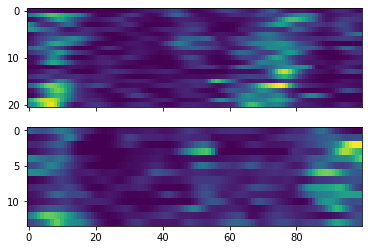

In [4]:
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].imshow(fr_map_[0][unit_ind_in_pyr].T,aspect='auto')
ax[1].imshow(fr_map_[1][unit_ind_in_pyr].T,aspect='auto')
# ax[1].set_xticklabels()

In [4]:
regressors_one_trial = {}
tt=0
mask = regressors['trial_type']==tt
regressors_one_trial['position'] = regressors['position'][mask]
regressors_one_trial['trial_inds_int'] = regressors['trial_inds_int'][mask]
regressors_one_trial['trial_type_inds'] = {tt:regressors['trial_type_inds'][tt]}
regressors_one_trial['trial_type'] = regressors['trial_type'][mask]
regressors_one_trial['dt'] = regressors['dt']
target_spk_one_trial = target_spk_allneurons[mask]
target_spk_one_trial_oneneuron = target_spk_one_trial[:,0]


In [5]:
reload(glmc)
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

In [6]:
key = jax.random.PRNGKey(0)
# fit_kwargs=dict(reg_type = 'gaussian_logprior_laplacian',lr=0.05,loss_type='poisson',niters=4000,nfields_max=2)
fit_kwargs=dict(lr=0.05,niters=4000)
target_all_neurons = target_spk_one_trial
regressors_ = regressors_one_trial
regressors_['ntrials'] = len(numpy.unique(regressors_['trial_inds_int']))
reg_pars = gm.get_reg_pars({'g_w':1000.,'g_b':10000.,'g_sigma_thresh':100000.,'sigma_thresh':3,'g_sigma_shrinkage':0.,'nfields_mask':np.array([1,1])})
# pars_learned, train_loss_with_reg, test_loss = cv_all_neurons_one_mask_one_reg_pars(key,mask,target_all_neurons,regressors_,reg_pars,fit_kwargs=fit_kwargs)


# %time cv_all_neurons_one_mask_one_reg_pars(key,None,target_all_neurons,regressors_,reg_pars,fit_kwargs=fit_kwargs,nfields_max=2)


In [28]:
reload(glmc)

<module 'glm_cv' from '/mnt/home/szheng/projects/util_code/glm_cv.py'>

In [29]:
%%time
cv_kwargs_={'cv_fold':3}
fit_kwargs_=dict(lr=0.05,niters=1,nfields_max=3)
reg_pars_tosweep_kwargs_ = reg_pars_tosweep_kwargs_={'g_w':[0.00001,100.],'g_b':[100.],'nfields':[1,2]}
reg_pars_ = gm.get_reg_pars({'g_w':1000.,'g_b':10000.,'g_sigma_thresh':100000.,'sigma_thresh':3,'g_sigma_shrinkage':0.})
save_kwargs_ = {'dir':os.path.join(py_data_dir,'glm_deterministic'),'fn':f'cv_trial0_allneuron.p'}
fn_full, cv_kwargs, fit_kwargs, reg_pars_l, reg_pars_name, mask_l, reg_pars_df=glmc.cv_prep(regressors_,reg_pars_tosweep_kwargs_=reg_pars_tosweep_kwargs_,reg_pars_=reg_pars_,fit_kwargs_=fit_kwargs_,cv_kwargs_=cv_kwargs_,save_kwargs_={})


nfields_mask_l = reg_pars_l['nfields_mask']
# %time glmc.cv_allneurons_allregpars_onemask(key,target_spk_one_trial,regressors_,reg_pars_l,mask=mask_l[0],fit_kwargs=fit_kwargs)
dosave = False
%time res=glmc.cv_all_neurons(target_spk_one_trial,regressors_,reg_pars_tosweep_kwargs_=reg_pars_tosweep_kwargs_,reg_pars_=reg_pars_,fit_kwargs_=fit_kwargs_,cv_kwargs_=cv_kwargs_,dosave=dosave,save_kwargs_=save_kwargs_,forcereload=True,key_int=0,col_names=cell_cols['pyr'])



CPU times: user 22.3 s, sys: 2.27 s, total: 24.6 s
Wall time: 10.7 s
CPU times: user 22.4 s, sys: 2.27 s, total: 24.6 s
Wall time: 10.7 s


In [6]:
save_kwargs_ = {'dir':os.path.join(py_data_dir,'glm_deterministic'),'fn':f'cv_trial0_allneuron.p'}
res=pickle.load(open(os.path.join(save_kwargs_['dir'],'cv_trial1_allneuron.p'),'rb'))

In [7]:
res['loss']

,S_l1,g_mu,g_sigma,g_w,g_b,sigma_thresh,g_sigma_thresh,nfields,g_order,g_sigma_shrinkage,...,unit_367,unit_368,unit_369,unit_370,unit_371,unit_372,unit_373,unit_374,unit_375,unit_376
0,100000000.0,200.0,1000.0,0.00001,0.00001,3,100000.0,1,1000.0,0.0,...,0.063045,0.186479,0.079304,0.114321,0.126162,0.204514,0.273938,0.102385,0.202534,0.173807
1,100000000.0,200.0,1000.0,0.00001,0.00001,3,100000.0,2,1000.0,0.0,...,0.577656,1.328757,0.570914,0.267010,0.306874,0.622722,0.582891,1.300505,0.322747,0.641551
2,100000000.0,200.0,1000.0,0.00001,0.00100,3,100000.0,1,1000.0,0.0,...,0.093431,0.083541,0.292285,0.127073,0.135617,0.542275,0.204147,0.207729,0.236548,0.297803
3,100000000.0,200.0,1000.0,0.00001,0.00100,3,100000.0,2,1000.0,0.0,...,0.253233,0.155321,0.189398,0.419918,0.848889,0.595295,0.263412,0.310015,0.636253,0.461387
4,100000000.0,200.0,1000.0,100.00000,0.00001,3,100000.0,1,1000.0,0.0,...,0.044744,0.177698,0.360893,0.118861,0.275421,0.023856,0.319059,0.163969,0.160487,0.110699
5,100000000.0,200.0,1000.0,100.00000,0.00001,3,100000.0,2,1000.0,0.0,...,1.126320,0.234916,0.914464,0.314607,0.233359,0.767711,0.213445,0.183357,0.094037,0.969916
6,100000000.0,200.0,1000.0,100.00000,0.00100,3,100000.0,1,1000.0,0.0,...,0.198330,0.185647,0.204647,0.256921,0.191479,0.084725,0.139809,0.378459,0.052408,0.179190
7,100000000.0,200.0,1000.0,100.00000,0.00100,3,100000.0,2,1000.0,0.0,...,0.477857,0.220799,0.641231,0.364052,0.440514,0.391695,0.409090,0.195205,0.063960,0.644254


In [19]:
np.concatenate([np.array([1,2]),np.array([3,4])],axis=1)

ValueError: axis 1 is out of bounds for array of dimension 1

In [15]:
res[0][0]

{'delta_b': DeviceArray([[[[-0.7769885 ],
                [ 1.8270359 ],
                [-0.18083096],
                ...,
                [ 0.921124  ],
                [ 0.59641933],
                [-0.6774001 ]],
 
               [[-0.23708963],
                [-1.2494411 ],
                [-1.7100759 ],
                ...,
                [ 1.7233548 ],
                [-0.472095  ],
                [-0.80193615]],
 
               [[ 0.9836607 ],
                [ 1.8901029 ],
                [-0.5652938 ],
                ...,
                [-0.64007854],
                [-0.94799614],
                [ 0.8329544 ]],
 
               ...,
 
               [[-0.21762991],
                [-0.60776424],
                [ 0.68384266],
                ...,
                [-1.099535  ],
                [ 0.21696568],
                [-0.83446836]],
 
               [[-1.817132  ],
                [-0.23532295],
                [-1.1847634 ],
                ...,
             

In [14]:
res[0][-1]

(4, 333)

In [8]:
key = jax.random.PRNGKey(1)

In [25]:
logpdf_no_reg=jax.jit(glm.logpdf_no_reg)
n_neurons = target_spk_allneurons.shape[1]
key_l = jax.random.split(key,n_neurons)
pars_trans_init_all = vmap(glm.random_init_jax,in_axes=(0,None))(key_l,regressors_)
# logpdf_no_reg_vmap = vmap(logpdf_no_reg,in_axes=(None,0,1,None))
# %timeit logpdf_no_reg_vmap(regressors_,pars_trans_init_all,target_spk_one_trial,np.array([1,1,1,1,1])).block_until_ready()

nfields_mask = np.array([1,1,0,0,0])

# %time vmap(glm.train_adam,in_axes=(None,0,1,None,None,None,None,None,None,None))(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,4000,None)
train_adam_allneurons =vmap(glm.train_adam,in_axes=(None,0,1,None,None,None,None,None,None,None))
train_adam_allneurons_allmasks=vmap(train_adam_allneurons,in_axes=(None,None,None,None,None,None,None,None,None,0))
%time train_adam_allneurons_allmasks(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,4000,mask_l)




CPU times: user 3min 18s, sys: 210 ms, total: 3min 18s
Wall time: 3min 18s


{'delta_b': DeviceArray([[[[ 0.31505355],
                [ 1.4046776 ],
                [ 2.4942923 ],
                ...,
                [-0.28080577],
                [-0.29792523],
                [-0.31505424]],
 
               [[ 0.02981463],
                [ 0.696119  ],
                [ 1.3608164 ],
                ...,
                [-0.01785955],
                [-0.04081985],
                [-0.06369258]],
 
               [[ 2.310589  ],
                [ 2.070464  ],
                [ 1.8303155 ],
                ...,
                [-0.23133162],
                [-1.2709601 ],
                [-2.3106015 ]],
 
               ...,
 
               [[ 0.52454203],
                [-0.15031528],
                [-0.82517296],
                ...,
                [-1.7536297 ],
                [-1.1390761 ],
                [-0.5245218 ]],
 
               [[-1.1234491 ],
                [-2.3566759 ],
                [-3.5899029 ],
                ...,
             

In [28]:
train_adam_allneurons_allmasks_jit=jit(vmap(train_adam_allneurons,in_axes=(None,None,None,None,None,None,None,None,None,0)))
train_adam_allneurons_allmasks_jit(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,1,mask_l[:1])
%time train_adam_allneurons_allmasks_jit(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,4000,mask_l)


CPU times: user 3min 18s, sys: 89.7 ms, total: 3min 18s
Wall time: 3min 18s


{'delta_b': DeviceArray([[[[ 0.31505734],
                [ 1.4046587 ],
                [ 2.4942925 ],
                ...,
                [-0.28080446],
                [-0.29792508],
                [-0.3150546 ]],
 
               [[ 0.02981496],
                [ 0.69612247],
                [ 1.3608232 ],
                ...,
                [-0.01786135],
                [-0.04082094],
                [-0.06369293]],
 
               [[ 2.3106017 ],
                [ 2.0704536 ],
                [ 1.8303634 ],
                ...,
                [-0.2313226 ],
                [-1.2709589 ],
                [-2.3106017 ]],
 
               ...,
 
               [[ 0.5245417 ],
                [-0.1503155 ],
                [-0.8251733 ],
                ...,
                [-1.7536296 ],
                [-1.1390758 ],
                [-0.5245219 ]],
 
               [[-1.1234487 ],
                [-2.3566756 ],
                [-3.5899029 ],
                ...,
             

In [29]:
%%time
for mask in mask_l:
    train_adam_allneurons(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,4000,mask)

CPU times: user 4min 5s, sys: 131 ms, total: 4min 6s
Wall time: 4min 6s


In [44]:
reload(glmc)

<module 'glm_cv' from '/mnt/home/szheng/projects/util_code/glm_cv.py'>

In [55]:
@jit
def x(l):
    return np.zeros(l)

In [45]:
nneurons = target_spk_allneurons.shape[1]
key_l = jax.random.split(key,nneurons)
regressors_['ntrials']=len(np.unique(regressors_['trial_inds_int']))

%time vmap(glmc.train_and_test,in_axes=(0,1,None,None,None,None,None,None,None,None,None))(key_l,target_spk_one_trial,regressors_,nfields_mask,reg_pars,0,mask_l[0],0,4000,0.05,5)



CPU times: user 27.3 s, sys: 220 ms, total: 27.5 s
Wall time: 27.4 s


({'delta_b': DeviceArray([[[ 0.31364998],
                [ 1.4043046 ],
                [ 2.49496   ],
                ...,
                [-0.2786544 ],
                [-0.295846  ],
                [-0.31303978]],
  
               [[ 0.1099197 ],
                [ 1.1220667 ],
                [ 2.1343544 ],
                ...,
                [-0.8458402 ],
                [-0.5231852 ],
                [-0.2003494 ]],
  
               [[ 2.3101456 ],
                [ 2.0703664 ],
                [ 1.834164  ],
                ...,
                [-0.23014252],
                [-1.2700616 ],
                [-2.3097878 ]],
  
               ...,
  
               [[ 0.4933838 ],
                [-0.18029031],
                [-0.8539642 ],
                ...,
                [-1.7878033 ],
                [-1.1407431 ],
                [-0.49368137]],
  
               [[-1.1243297 ],
                [-2.358195  ],
                [-3.5920513 ],
                ...,
        

In [ ]:
def train_and_test_all_neurons(key,target,regressors,nfields_mask,reg_pars_={},reg_type = 'gaussian_logprior_laplacian',mask=None,loss_type='poisson',niters=4000,lr=0.05,nfields_max=5):
    
    

In [47]:
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

In [50]:
def train_and_test_all_neurons(key,target,regressors,nfields_mask,reg_pars_={},reg_type = 'gaussian_logprior_laplacian',mask=None,loss_type='poisson',niters=4000,lr=0.05,nfields_max=5):

    '''
    given a set of hyperparam, and mask: train on the train set get par and loss, and get test loss
    '''
    
    if mask is None:
        mask = np.ones_like(target)
    # key = jax.random.PRNGKey(key_int)
    n_neurons = target.shape[1]
    key_l=jax.random.split(key,n_neurons)
    pars_trans_init_allneurons=glm.random_init_jax_allneurons(key_l,regressors,nfields_max)
#     pars_trans_init=vmap(glm.random_init_jax(key_l,regressors,nfields_max=nfields_max,uncentered=True)
    # prepare regressors and hyperparams
    # train
    # pars_learned_trans,loss_l = gm.train_adam(glm.negative_logpdf,regressors,pars_trans_init,target,reg_pars_,nfields_mask,reg_type = reg_type,mask=mask,loss_type=loss_type,niters=niters,lr=lr)
    pars_learned_trans = glm.train_adam_allneurons_same_regpars(regressors,pars_trans_init_allneurons,target,reg_pars_,nfields_mask,reg_type,mask,loss_type,niters,lr)

    # test
    test_loss = vmap(glm.negative_logpdf_no_reg,in_axes=(None,0,1,None,None,None))(regressors,pars_learned_trans,target,nfields_mask,np.logical_not(mask),loss_type)
    # return pars_learned_trans, loss_l, test_loss
    return pars_learned_trans, test_loss


In [12]:
cv_kwargs={'cv_fold':10,'mask_ratio':0.2}
mask_l = np.array([glmc.get_train_test_mask_from_space(regressors_,ratio_consec_bins_to_mask=cv_kwargs['mask_ratio']) for _ in range(cv_kwargs['cv_fold'])])



In [78]:
reload(glmc)

<module 'glm_cv' from '/mnt/home/szheng/projects/util_code/glm_cv.py'>

In [64]:
res[0]['delta_b'].shape

(3, 2, 333, 21, 1)

In [72]:
n_neurons=333
res[1].swapaxes(2,1).swapaxes(0,1).reshape(n_neurons,-1).T

(6, 333)

In [13]:
nfields_mask=np.array([1,1,0,0,0])
glmc.train_and_test_all_neurons(key,target_spk_one_trial,regressors_,nfields_mask,reg_pars_=reg_pars,reg_type = 0,mask=mask_l[0],loss_type=0,niters=1,lr=0.05,nfields_max=5)
%time glmc.train_and_test_all_neurons(key,target_spk_one_trial,regressors_,nfields_mask,reg_pars_=reg_pars,reg_type = 0,mask=mask_l[0],loss_type=0,niters=4000,lr=0.05,nfields_max=5)



CPU times: user 24.4 s, sys: 11.3 ms, total: 24.5 s
Wall time: 24.4 s


({'delta_b': DeviceArray([[[ 0.273077  ],
                [ 1.5652943 ],
                [-0.48112774],
                ...,
                [-0.22588015],
                [ 1.4526682 ],
                [ 1.9605675 ]],
  
               [[-1.4497738 ],
                [ 0.722909  ],
                [ 0.00802183],
                ...,
                [ 1.228642  ],
                [ 1.5392604 ],
                [-1.9725404 ]],
  
               [[ 0.8317375 ],
                [ 1.0435653 ],
                [ 0.5392308 ],
                ...,
                [ 1.9115467 ],
                [ 1.1335187 ],
                [-0.9691038 ]],
  
               ...,
  
               [[-0.07027197],
                [-0.42250156],
                [ 0.33464956],
                ...,
                [ 0.0625596 ],
                [-1.2770481 ],
                [ 1.1374803 ]],
  
               [[-0.08304691],
                [-0.29585218],
                [ 1.4996219 ],
                ...,
        

In [55]:
logpdf_no_reg_vmap_nojit = vmap(glm.logpdf_no_reg,in_axes=(None,0,1,None))
%timeit logpdf_no_reg_vmap_nojit(regressors_,pars_trans_init_all,target_spk_one_trial,np.array([1,1,1,1,1])).block_until_ready()

1.99 ms ± 55.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
key = jax.random.PRNGKey(0)
pars_trans_init = glm.random_init_jax(key,regressors_)

In [86]:
func_jitted(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,np.array([1,1,1,1,1]),reg_pars=reg_pars).block_until_ready()
%timeit func_jitted(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,np.array([1,1,1,1,1]),reg_pars=reg_pars).block_until_ready()



461 µs ± 3.55 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [89]:
func_notjitted(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,np.array([1,1,1,1,1]),reg_pars=reg_pars).block_until_ready()
%timeit func_notjitted(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,np.array([1,1,1,1,1]),reg_pars=reg_pars).block_until_ready()



6.77 ms ± 86.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

In [84]:
# compare train adam

func_jitted = jit(glm.negative_logpdf)
nfields_mask = np.array([1,1,1,1,1])
gm.train_adam(func_jitted,regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=0.1,niters=1,mask=None)
%time gm.train_adam(func_jitted,regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=0.1,niters=4000,mask=None)


CPU times: user 3.02 s, sys: 487 ms, total: 3.51 s
Wall time: 2.92 s


({'delta_b': DeviceArray([[ 0.32267946],
               [ 0.25696442],
               [ 0.1912523 ],
               [ 0.1651846 ],
               [ 0.1390556 ],
               [ 0.1604747 ],
               [ 0.18174934],
               [ 0.22441539],
               [ 0.2670463 ],
               [ 0.3096151 ],
               [ 0.35216424],
               [ 0.39468464],
               [ 0.08238727],
               [ 0.17304316],
               [ 0.25141132],
               [ 0.32967064],
               [ 0.25108004],
               [ 0.17244498],
               [ 0.04351505],
               [-0.12932454],
               [-0.30226573]], dtype=float32),
  'delta_ws': DeviceArray([[ -0.62001497,  -0.4513253 ,  -0.18163213,  -0.12667018,
                 -0.42452642],
               [  9.008926  ,  19.204105  ,   6.3767853 ,  14.1537285 ,
                 18.171822  ],
               [ -0.41585356,  -4.0838027 ,  -1.6950835 ,   0.9011133 ,
                  0.12764041],
               [ -1.2

In [81]:
# compare train adam

func_notjitted = glm.negative_logpdf
nfields_mask = np.array([1,1,1,1,1])
%time gm.train_adam(func_notjitted,regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=0.1,niters=4000,mask=None)


2.77 s ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
from jax.example_libraries import optimizers as jax_opt
from jax import value_and_grad, grad, jit, vmap, jacfwd, jacrev

def train_adam(func,regressors,pars,ys_l,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=0.1,niters=100,mask=None):
# def train_adam(func,*args,argnums=1,lr=0.1,niters=100,**kwargs):
    opt_init,opt_update,get_params=jax_opt.adam(lr)
#     loss_l=np.array([])
#     func = glm.negative_logpdf
    @jit
    def train_step(step_i,opt_state):
#         loss_l, opt_state = args
        params=get_params(opt_state)
        loss,grads = value_and_grad(func,argnums=1)(regressors,params,ys_l,nfields_mask,reg_pars=reg_pars,loss_type=loss_type,reg_type=reg_type,mask=mask) # notice the params here
        # loss,grads = value_and_grad(func,argnums=argnums)(*args,**kwargs)
#         loss_l = np.append(loss_l,loss)
#         return (loss_l,opt_update(step_i, grads, opt_state))
        return opt_update(step_i, grads, opt_state)
    # opt_state=opt_init(args[argnums])
    opt_state=opt_init(pars)
#     args = (loss_l,opt_state)
#     for ii in range(niters):
    opt_state= jax.lax.fori_loop(0,niters,train_step,opt_state)
#         loss,opt_state = train_step(ii,opt_state)
#         loss_l.append(loss)
#     return get_params(opt_state), np.array(loss_l)
    return get_params(opt_state)

train_adam_jit = jit(train_adam)




In [27]:
# compare train adam

func_notjitted = glm.negative_logpdf
nfields_mask = np.array([1,1,1,1,1])
train_adam_jit(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=0.1,niters=1,mask=None)
%timeit train_adam_jit(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=0.1,niters=4000,mask=None)


6.71 s ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
# %time train_adam(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=0.1,niters=4000,mask=None)
%time train_adam(glm.negative_logpdf,regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=0.1,niters=4000,mask=None)



CPU times: user 12.3 s, sys: 185 ms, total: 12.5 s
Wall time: 9.46 s


{'delta_b': DeviceArray([[ 0.3226787 ],
              [ 0.2569651 ],
              [ 0.19125377],
              [ 0.1651842 ],
              [ 0.13905264],
              [ 0.1604695 ],
              [ 0.18174621],
              [ 0.22441125],
              [ 0.26704141],
              [ 0.30961236],
              [ 0.35216427],
              [ 0.39468682],
              [ 0.08238905],
              [ 0.17304331],
              [ 0.25141153],
              [ 0.32967135],
              [ 0.25108132],
              [ 0.17244719],
              [ 0.04351587],
              [-0.12932305],
              [-0.3022636 ]], dtype=float32),
 'delta_ws': DeviceArray([[ -0.6199846 ,  -0.45132455,  -0.18163213,  -0.12667076,
                -0.42453283],
              [  9.008926  ,  19.204105  ,   6.3767853 ,  14.1537285 ,
                18.171822  ],
              [ -0.4159037 ,  -4.083794  ,  -1.6950841 ,   0.9011238 ,
                 0.127612  ],
              [ -1.2491837 ,   5.3242455 , -13.6

In [11]:
%timeit glm.train_adam(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=0.1,niters=4000,mask=None)



NameError: name 'pars_trans_init' is not defined

In [131]:
#compare train adam vmap
train_adam_jit_vmap = vmap(train_adam_jit,in_axes=(None,0,1,None,None,None,None,None,None,None))
train_adam_vmap = vmap(train_adam,in_axes=(None,0,1,None,None,None,None,None,None,None))


In [119]:



train_adam_jit_vmap(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,1,None)
%time train_adam_jit_vmap(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,4000,None)



CPU times: user 22.9 s, sys: 0 ns, total: 22.9 s
Wall time: 22.9 s


{'delta_b': DeviceArray([[[ 0.43202516],
               [ 0.24979705],
               [ 0.06762251],
               ...,
               [-0.28901726],
               [-0.35582897],
               [-0.42273086]],
 
              [[ 1.0698377 ],
               [ 0.61342436],
               [ 0.15672621],
               ...,
               [-3.5472364 ],
               [-2.2678568 ],
               [-0.9886742 ]],
 
              [[-0.00800731],
               [-0.08306293],
               [-0.15811847],
               ...,
               [-0.15805654],
               [-0.09075785],
               [-0.02348012]],
 
              ...,
 
              [[-0.01481954],
               [ 1.2156879 ],
               [ 2.446292  ],
               ...,
               [ 0.6457412 ],
               [ 0.3008168 ],
               [-0.04401685]],
 
              [[-0.8454752 ],
               [-2.00008   ],
               [-3.1546838 ],
               ...,
               [-1.0646417 ],
               [

In [120]:
train_adam_vmap(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,1,None)
%time train_adam_vmap(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,4000,None)


CPU times: user 12.2 s, sys: 9.57 s, total: 21.7 s
Wall time: 21.6 s


{'delta_b': DeviceArray([[[ 0.432024  ],
               [ 0.24979675],
               [ 0.06762267],
               ...,
               [-0.28901666],
               [-0.3558277 ],
               [-0.42273006]],
 
              [[ 1.069839  ],
               [ 0.6134207 ],
               [ 0.15672044],
               ...,
               [-3.547239  ],
               [-2.267857  ],
               [-0.9886735 ]],
 
              [[-0.00800734],
               [-0.08306315],
               [-0.1581189 ],
               ...,
               [-0.1580561 ],
               [-0.09075762],
               [-0.0234801 ]],
 
              ...,
 
              [[-0.01481956],
               [ 1.2156867 ],
               [ 2.44629   ],
               ...,
               [ 0.64573807],
               [ 0.30081522],
               [-0.04401657]],
 
              [[-0.84547377],
               [-2.0000787 ],
               [-3.1546834 ],
               ...,
               [-1.0646417 ],
               [

In [132]:
train_adam_vmap(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,1,None)
%time train_adam_vmap(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,4000,None)


2022-08-11 23:25:14.294649: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:62] Constant folding an instruction is taking > 1s:

  select.56 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2022-08-11 23:25:14.303767: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:131] The operation took 1.00920684s
Constant folding an instruction is taking > 1s:

  select.56 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't ne

CPU times: user 1min 26s, sys: 14 s, total: 1min 40s
Wall time: 1min 39s


{'delta_b': DeviceArray([[[ 0.43202633],
               [ 0.24979843],
               [ 0.06762391],
               ...,
               [-0.28901336],
               [-0.3558262 ],
               [-0.4227284 ]],
 
              [[ 1.0698341 ],
               [ 0.6134297 ],
               [ 0.15672469],
               ...,
               [-3.5472383 ],
               [-2.267859  ],
               [-0.98867446]],
 
              [[-0.00800727],
               [-0.08306257],
               [-0.15811783],
               ...,
               [-0.1580559 ],
               [-0.0907575 ],
               [-0.02348007]],
 
              ...,
 
              [[-0.01481941],
               [ 1.2156857 ],
               [ 2.4462886 ],
               ...,
               [ 0.6457401 ],
               [ 0.3008162 ],
               [-0.04401665]],
 
              [[-0.84547514],
               [-2.0000796 ],
               [-3.1546838 ],
               ...,
               [-1.0646427 ],
               [

In [124]:
def train_adam_vmap_jit_loop(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=0.1,niters=4000,mask=None):
    train_adam_jit_vmap(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type,reg_type,lr,1,mask)
    for i in range(2):
        train_adam_jit_vmap(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type,reg_type,lr,niters,mask)
        


In [125]:
def train_adam_vmap_loop(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=0.1,niters=4000,mask=None):
    train_adam_vmap(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type,reg_type,lr,1,mask)
    for i in range(2):
        train_adam_vmap(regressors_,pars_trans_init,target_spk_one_trial_oneneuron,reg_pars,nfields_mask,loss_type,reg_type,lr,niters,mask)
        


In [123]:
%time train_adam_vmap_jit_loop(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,4000,None)





CPU times: user 45.8 s, sys: 0 ns, total: 45.8 s
Wall time: 45.8 s


In [126]:
%time train_adam_vmap_loop(regressors_,pars_trans_init_all,target_spk_one_trial,reg_pars,nfields_mask,0,0,0.1,4000,None)


CPU times: user 27 s, sys: 18.4 s, total: 45.4 s
Wall time: 44.7 s


In [83]:
selu_jit = jax.jit(selu)

# Warm up
selu_jit(x).block_until_ready()

%timeit selu_jit(x).block_until_ready()

29.2 µs ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [48]:
train_and_test = glmc.train_and_test
from functools import partial
@partial(jax.jit, static_argnames=('nfields_max',))
def cv_all_neurons_one_mask_one_reg_pars(key,mask,target_all_neurons,regressors,reg_pars,fit_kwargs=dict(lr=0.05,niters=4000),nfields_max=5):
    nfields_mask = reg_pars['nfields_mask']
    n_neurons = target_all_neurons.shape[1]
    key_l = jax.random.split(key,num=n_neurons)
    train_and_test_wrapper=lambda key,target: train_and_test(key,target,regressors,nfields_mask,reg_pars_=reg_pars,mask=mask,reg_type = 'gaussian_logprior_laplacian',loss_type='poisson',**fit_kwargs)
    pars_learned,train_loss_with_reg,test_loss= vmap(train_and_test_wrapper,in_axes=(0,1))(key_l,target_all_neurons)
    return pars_learned, train_loss_with_reg, test_loss
    

    

In [8]:
key = jax.random.PRNGKey(0)
# fit_kwargs=dict(reg_type = 'gaussian_logprior_laplacian',lr=0.05,loss_type='poisson',niters=4000,nfields_max=2)
fit_kwargs=dict(lr=0.05,niters=4000)
target_all_neurons = target_spk_one_trial
regressors_ = regressors_one_trial
regressors_['ntrials'] = len(numpy.unique(regressors_['trial_inds_int']))
reg_pars = gm.get_reg_pars({'g_w':1000.,'g_b':10000.,'g_sigma_thresh':100000.,'sigma_thresh':3,'g_sigma_shrinkage':0.,'nfields_mask':np.array([1,1])})
# pars_learned, train_loss_with_reg, test_loss = cv_all_neurons_one_mask_one_reg_pars(key,mask,target_all_neurons,regressors_,reg_pars,fit_kwargs=fit_kwargs)


# %time cv_all_neurons_one_mask_one_reg_pars(key,None,target_all_neurons,regressors_,reg_pars,fit_kwargs=fit_kwargs,nfields_max=2)


no jit: CPU times: user 1min 26s, sys: 13.1 s, total: 1min 39s
Wall time: 1min 38s

In [ ]:
def cv_one_neuron_one_mask(key,mask,target,regressors,reg_pars_l,fit_kwargs=dict(reg_type = 'gaussian_logprior_laplacian',lr=0.05,loss_type='poisson',niters=4000),nfields_max=5):
    # mask = get_train_test_mask_from_space(regressors,ratio_consec_bins_to_mask=cv_kwargs['mask_ratio'])
    # nfields_l = np.array([rp_['nfields'] for rp_ in reg_pars_l] )
    nfields_mask_l=reg_pars_l['nfields_mask']
    key_l = jax.random.split(key,num=nfields_mask_l.shape[0])
    # pars_trans_init_l = vmap(glm.random_init_jax,in_axes=(0,None,None,0))(key_l,regressors,ntrials,nfields_l)
    train_and_test_wrapper=lambda key,rp_,nfields_mask,mask: train_and_test(key,target,regressors,nfields_mask,reg_pars_=rp_,mask=mask,**fit_kwargs)
    pars_learned_l,_,test_loss_l= vmap(train_and_test_wrapper,in_axes=(0,0,0,None))(key_l,reg_pars_l,nfields_mask_l,mask)
    loss_noreg_wrapper=lambda par,nfields_mask:glm.negative_logpdf_no_reg(regressors,par,target,nfields_mask,mask=mask,loss_type=fit_kwargs['loss_type'])
    train_loss_l = vmap(loss_noreg_wrapper)(pars_learned_l,nfields_mask_l)
    return pars_learned_l, train_loss_l, test_loss_l


In [27]:
%%time 
target_all_neurons = target_spk_one_trial
regressors_ = regressors_one_trial


fit_kwargs_=dict(reg_type = 'gaussian_logprior_laplacian',lr=0.05,loss_type='poisson',niters=4000,nfields_max=4)
reg_pars_ = gm.get_reg_pars({'g_w':1000.,'g_b':10000.,'g_sigma_thresh':100000.,'sigma_thresh':3,'g_sigma_shrinkage':0.})
# reg_pars_tosweep_kwargs_={'g_w':[0.01,1.,10.,100.,10000.],'g_b':[1.,100.,10000.],'nfields':[1,2,3,4]}
reg_pars_tosweep_kwargs_={'g_w':[0.0001,0.001,0.01,1.,100.],'g_b':[0.001,0.1,10.,10000.],'nfields':[1,2,3,4]}
# reg_pars_tosweep_kwargs_={'g_w':[1.]}
dosave = True
forcereload=True
cv_kwargs_={'cv_fold':10}
# cv_fold_actual = 10
# for cvi in range(cv_fold_actual):
# cvi=0
# print(cvi)
# save_kwargs_ = {'dir':os.path.join(py_data_dir,'glm_deterministic'),'fn':f'cv_trial0_allneuron{cvi}.p'}
save_kwargs_ = {'dir':os.path.join(py_data_dir,'glm_deterministic'),'fn':f'cv_trial0_allneuron.p'}
res = glmc.cv_all_neurons(target_all_neurons,regressors_,reg_pars_tosweep_kwargs_=reg_pars_tosweep_kwargs_,reg_pars_=reg_pars_,fit_kwargs_=fit_kwargs_,cv_kwargs_=cv_kwargs_,dosave=dosave,save_kwargs_=save_kwargs_,forcereload=forcereload,key_int=cvi)


2022-08-11 00:27:23.745128: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 174.19GiB (rounded to 187031981824)requested by op 
2022-08-11 00:27:23.745379: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:491] *****_______________________________________________________________________________________________
2022-08-11 00:27:23.745664: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2129] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 187031981768 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  119.92MiB
              constant allocation:  104.62MiB
        maybe_live_out allocation:  360.76MiB
     preallocated temp allocation:  174.19GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  174.76GiB
    

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 187031981768 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  119.92MiB
              constant allocation:  104.62MiB
        maybe_live_out allocation:  360.76MiB
     preallocated temp allocation:  174.19GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  174.76GiB
              total fragmentation:  192.02MiB (0.11%)
Peak buffers:
	Buffer 1:
		Size: 139.34GiB
		Operator: op_name="jit(train_step)/jit(main)/transpose(jvp(jit(forward)))/vmap(jit(<lambda>))/jit(unnormalized_normal_pdf)/mul" source_file="/mnt/home/szheng/projects/util_code/math_functions.py" source_line=11
		XLA Label: fusion
		Shape: f32[333,10,80,4,35102]
		==========================

	Buffer 2:
		Size: 34.83GiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(forward))/mul" source_file="/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py" source_line=125
		XLA Label: fusion
		Shape: f32[333,10,80,35102]
		==========================

	Buffer 3:
		Size: 85.36MiB
		Entry Parameter Subshape: f32[333,10,80,21,4]
		==========================

	Buffer 4:
		Size: 85.36MiB
		Operator: op_name="jit(train_step)/jit(main)/sub" source_file="/mnt/home/szheng/projects/util_code/gm.py" source_line=330
		XLA Label: fusion
		Shape: f32[333,10,80,21,4]
		==========================

	Buffer 5:
		Size: 85.36MiB
		Operator: op_name="jit(train_step)/jit(main)/sub" source_file="/mnt/home/szheng/projects/util_code/gm.py" source_line=330
		XLA Label: fusion
		Shape: f32[333,10,80,21,4]
		==========================

	Buffer 6:
		Size: 85.36MiB
		Operator: op_name="jit(train_step)/jit(main)/sub" source_file="/mnt/home/szheng/projects/util_code/gm.py" source_line=330
		XLA Label: fusion
		Shape: f32[333,10,80,21,4]
		==========================

	Buffer 7:
		Size: 44.59MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(logpdf_poisson_reduce))/sub" source_file="/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py" source_line=218
		XLA Label: constant
		Shape: f32[333,35102]
		==========================

	Buffer 8:
		Size: 44.59MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(logpdf_poisson_reduce))/mul" source_file="/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py" source_line=218
		XLA Label: constant
		Shape: f32[333,35102]
		==========================

	Buffer 9:
		Size: 21.34MiB
		Entry Parameter Subshape: f32[333,10,80,21,1]
		==========================

	Buffer 10:
		Size: 21.34MiB
		Operator: op_name="jit(train_step)/jit(main)/sub" source_file="/mnt/home/szheng/projects/util_code/gm.py" source_line=330
		XLA Label: fusion
		Shape: f32[333,10,80,21,1]
		==========================

	Buffer 11:
		Size: 21.34MiB
		Operator: op_name="jit(train_step)/jit(main)/add" source_file="/mnt/home/szheng/projects/util_code/gm.py" source_line=330
		XLA Label: fusion
		Shape: f32[333,10,80,21,1]
		==========================

	Buffer 12:
		Size: 21.34MiB
		Operator: op_name="jit(train_step)/jit(main)/add" source_file="/mnt/home/szheng/projects/util_code/gm.py" source_line=330
		XLA Label: fusion
		Shape: f32[333,10,80,21,1]
		==========================

	Buffer 13:
		Size: 11.15MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(jit(logpdf_poisson_reduce))/jit(_where)/transpose[permutation=(1, 0)]" source_file="/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py" source_line=218
		XLA Label: constant
		Shape: pred[333,35102]
		==========================

	Buffer 14:
		Size: 4.06MiB
		Operator: op_name="jit(train_step)/jit(main)/sub" source_file="/mnt/home/szheng/projects/util_code/gm.py" source_line=330
		XLA Label: fusion
		Shape: f32[333,10,80,1,4]
		==========================

	Buffer 15:
		Size: 4.06MiB
		Operator: op_name="jit(train_step)/jit(main)/sub" source_file="/mnt/home/szheng/projects/util_code/gm.py" source_line=330
		XLA Label: fusion
		Shape: f32[333,10,80,1,4]
		==========================



cvfold=10
CPU times: user 5min 42s, sys: 2min 26s, total: 8min 8s
Wall time: 8min 8s

In [26]:
(res['loss'][numpy.arange(333)].max(axis=0) - res['loss'][numpy.arange(333)].min(axis=0)).min()

0.00020241422

In [93]:
cv_fold = cv_kwargs_['cv_fold']
reg_pars_df_full = pd.concat([reg_pars_df]*cv_fold).reset_index(drop=True)
test_loss_all = res[2].reshape(n_neurons,-1) # res[2]: n_neurons x cv_fold x n_reg_pars 
cols = cell_cols['pyr']
test_loss_all_df = pd.DataFrame(numpy.array(test_loss_all.T),columns=cols)
test_loss_all_df = pd.concat([reg_pars_df_full,test_loss_all_df],axis=1)

In [94]:
test_loss_all_df

,S_l1,g_mu,g_sigma,g_w,g_b,sigma_thresh,g_sigma_thresh,nfields,g_order,g_sigma_shrinkage,...,unit_367,unit_368,unit_369,unit_370,unit_371,unit_372,unit_373,unit_374,unit_375,unit_376
0,100000000.0,200.0,1000.0,1.0,10000.0,3,100000.0,2,1000.0,0.0,...,0.192239,0.091138,0.063922,0.091955,0.116571,0.041579,0.062504,0.030487,0.015411,0.033748
1,100000000.0,200.0,1000.0,10.0,10000.0,3,100000.0,2,1000.0,0.0,...,0.205515,0.091022,0.047389,0.087927,0.112751,0.052827,0.018558,0.027859,0.015453,0.032918
2,100000000.0,200.0,1000.0,1.0,10000.0,3,100000.0,2,1000.0,0.0,...,0.182717,0.086925,0.045860,0.081888,0.078790,0.001172,0.005016,0.027016,0.019438,0.012188
3,100000000.0,200.0,1000.0,10.0,10000.0,3,100000.0,2,1000.0,0.0,...,0.443928,0.068009,0.087436,0.079719,0.106879,0.001141,0.004702,0.028029,0.009450,0.039457


In [91]:
test_loss_all_df

,S_l1,g_mu,g_sigma,g_w,g_b,sigma_thresh,g_sigma_thresh,nfields,g_order,g_sigma_shrinkage,...,unit_367,unit_368,unit_369,unit_370,unit_371,unit_372,unit_373,unit_374,unit_375,unit_376
0,100000000.0,200.0,1000.0,1.0,10000.0,3,100000.0,2,1000.0,0.0,...,0.284302,0.152692,0.277744,0.217731,0.350998,0.177736,1.281711,0.078644,0.030204,0.422998
1,100000000.0,200.0,1000.0,10.0,10000.0,3,100000.0,2,1000.0,0.0,...,0.349273,0.100758,0.420245,0.090750,0.193852,0.219036,0.423262,0.187996,0.215800,0.377605
2,100000000.0,200.0,1000.0,1.0,10000.0,3,100000.0,2,1000.0,0.0,...,0.246443,0.520413,0.200753,0.123609,0.229385,0.141061,0.102922,0.343878,0.604861,0.054780
3,100000000.0,200.0,1000.0,10.0,10000.0,3,100000.0,2,1000.0,0.0,...,0.386857,0.308133,0.182078,0.259863,0.197078,0.054257,0.042156,0.027831,0.353749,0.437360


In [84]:
test_loss_all_df

,S_l1,g_mu,g_sigma,g_w,g_b,sigma_thresh,g_sigma_thresh,nfields,g_order,g_sigma_shrinkage,...,unit_367,unit_368,unit_369,unit_370,unit_371,unit_372,unit_373,unit_374,unit_375,unit_376
0,100000000.0,200.0,1000.0,1.0,10000.0,3,100000.0,2,1000.0,0.0,...,0.324355,0.721153,2.122057,1.006202,2.016039,0.997733,2.256220,0.703276,0.117394,1.782204
1,100000000.0,200.0,1000.0,10.0,10000.0,3,100000.0,2,1000.0,0.0,...,1.347809,0.257240,1.250495,0.318384,1.212428,1.034316,1.311184,1.099974,1.306547,1.855198
2,100000000.0,200.0,1000.0,1.0,10000.0,3,100000.0,2,1000.0,0.0,...,0.847029,1.562518,0.804474,0.334654,0.598061,1.269062,1.047227,1.510641,2.123433,0.324934
3,100000000.0,200.0,1000.0,10.0,10000.0,3,100000.0,2,1000.0,0.0,...,1.148290,0.874692,0.615302,0.873261,0.449694,0.431114,0.597704,0.322425,1.688579,2.008815


In [62]:
res[2].reshape(n_neurons,-1)

DeviceArray([[1.0044311 , 1.1209332 , 0.3450137 , 1.6462672 ],
             [2.0956533 , 1.0722638 , 0.6741639 , 0.6627393 ],
             [2.0163026 , 0.548246  , 0.28368083, 0.89623576],
             ...,
             [0.70327586, 1.0999743 , 1.5106415 , 0.32242507],
             [0.11739448, 1.3065468 , 2.1234334 , 1.6885792 ],
             [1.7822039 , 1.855198  , 0.32493448, 2.008815  ]],            dtype=float32)

In [42]:
nfields_max=2
pars_trans_init=glm.random_init_jax(key,regressors,nfields_max=nfields_max,uncentered=True)
# prepare regressors and hyperparams
# train
pars_learned_trans,loss_l = gm.train_adam(glm.negative_logpdf,regressors,pars_trans_init,target_spk_allneurons[:,0],reg_pars_,np.array([1,1]),reg_type = None,mask=mask,loss_type='poisson',niters=1,lr=0.05)


In [31]:
key_int=0
key = jax.random.PRNGKey(key_int)
n_neurons = target_all_neurons.shape[1]
rngkey_l = jax.random.split(rngkey,n_neurons)
cv_kwargs_={'cv_fold':2}
fn_full, cv_kwargs, fit_kwargs, reg_pars_l, reg_pars_name, mask_l, reg_pars_df=glmc.cv_prep(regressors,reg_pars_tosweep_kwargs_=reg_pars_tosweep_kwargs_,reg_pars_=reg_pars_,fit_kwargs_=fit_kwargs_,cv_kwargs_=cv_kwargs_,save_kwargs_={},nfields_max=2)

glmc.cv_one_neuron_given_mask_l(key,target_spk_allneurons[:,0],regressors,cv_kwargs, fit_kwargs, reg_pars_l, reg_pars_name, mask_l, fn_full=fn_full)

# cv_one_neuron_given_mask_l_wrapper = lambda key,target:glmc.cv_one_neuron_given_mask_l(key,target,regressors,cv_kwargs, fit_kwargs, reg_pars_l, reg_pars_name, mask_l, fn_full=fn_full)
# res=vmap(cv_one_neuron_given_mask_l_wrapper,in_axes=(0,1))(rngkey_l,target_all_neurons)


TypeError: Incompatible shapes for dot: got (2,) and (5, 55038).